In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar la base limpia que generamos en la etapa de limpieza
#    Nota: df_cleaned.csv debe estar en la misma carpeta del script/notebook
df = pd.read_csv("df_cleaned.csv")

Shape del dataset: (20827, 105)

Primeras filas del dataset:
   host_since  host_response_time  host_response_rate  host_acceptance_rate  \
0  2019-12-14  within a few hours                 100                  54.0   
1  2013-01-19        within a day                  90                  69.0   
2  2019-09-16  within a few hours                  75                 100.0   
3  2014-04-29        Sin registro                 100                  60.0   
4  2013-07-25  a few days or more                   0                   0.0   

    latitude  longitude  accommodates  bathrooms  bathrooms_text  bedrooms  \
0  40.746980 -73.917630             1        1.0   1 shared bath       1.0   
1  40.721470 -73.982700             1        2.0  2 shared baths       1.0   
2  40.682300 -73.845450             6        1.0          1 bath       2.0   
3  40.713163 -73.943077             1        1.0   1 shared bath       2.0   
4  40.674120 -73.941230             6        4.0         4 baths       3.0

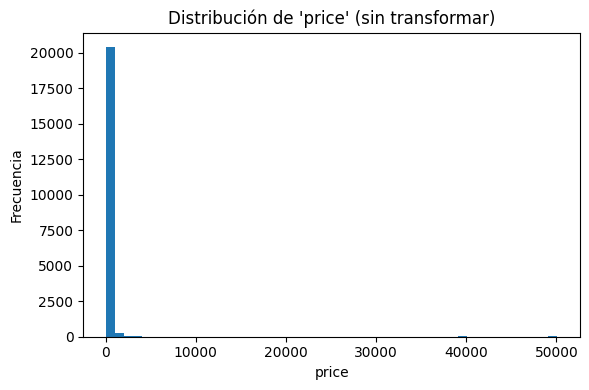

In [ ]:
# Revisar tamaño del dataset (filas, columnas) para tener una idea del orden de magnitud
print("Shape del dataset:", df.shape)

# Ver las primeras filas para confirmar que las columnas corresponden a lo esperado
print("\nPrimeras filas del dataset:")
print(df.head())

# Revisar tipos de datos para tener claro qué es numérico, categórico, etc.
print("\nResumen de tipos de datos:")
print(df.dtypes)

# Descripción básica de la variable objetivo original 'price'
#    Esto ayuda a ver rangos, promedio, percentiles, etc.
print("\nDescripción estadística de 'price':")
print(df["price"].describe())

# Histograma de 'price' sin transformar
#    La idea es visualizar la distribución cruda y ver si está muy sesgada
plt.figure(figsize=(6, 4))
plt.hist(df["price"], bins=50)
plt.title("Distribución de 'price' (sin transformar)")
plt.xlabel("price")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Percentil 1 de price: 37.0
Percentil 99 de price: 1910.0
Shape después de filtrar outliers de price: (20436, 105)

Descripción de 'log_price':
count    20436.000000
mean         5.073405
std          0.768963
min          3.610918
25%          4.499810
50%          5.030438
75%          5.598422
max          7.554859
Name: log_price, dtype: float64


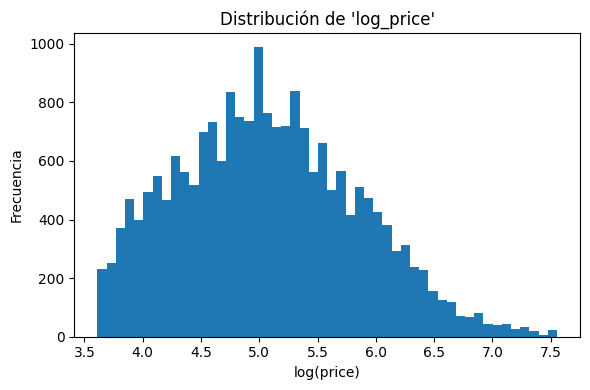

In [4]:
# Filtro simple de outliers de 'price' usando percentiles
p1 = df["price"].quantile(0.01)
p99 = df["price"].quantile(0.99)

print(f"Percentil 1 de price: {p1}")
print(f"Percentil 99 de price: {p99}")

# Me quedo con precios dentro de este rango para evitar valores extremos muy raros
df_model1 = df[(df["price"] >= p1) & (df["price"] <= p99)].copy()

print("Shape después de filtrar outliers de price:", df_model1.shape)

# Creo la variable objetivo transformada: logaritmo natural del precio
df_model1["log_price"] = np.log(df_model1["price"])

print("\nDescripción de 'log_price':")
print(df_model1["log_price"].describe())

# Histograma de log_price para ver que la distribución queda más razonable
plt.figure(figsize=(6, 4))
plt.hist(df_model1["log_price"], bins=50)
plt.title("Distribución de 'log_price'")
plt.xlabel("log(price)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Defino las columnas numéricas "básicas" que quiero usar directamente
base_feature_cols = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "amenities_count",
    "minimum_nights",
    "maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost:t",
    "has_tv",
    "has_wifi",
    "has_hot_water",
    "has_air_conditioning",
    "has_heating",
    "has_refrigerator",
    "has_kitchen",
    "has_pets_allowed",
    "has_coffee_maker",
    "has_dishes_and_silverware",
    "has_essentials",
    "has_free_parking",
    "has_email",
    "has_phone",
]

# Verifico que todas estas columnas existan en df_model1
missing_cols = [col for col in base_feature_cols if col not in df_model1.columns]
print("Columnas base faltantes (si hay):", missing_cols)

# Además de las numéricas básicas, incluyo las dummies de ubicación y tipo:
dummy_prefixes = [
    "neighbourhood_group_cleansed:",
    "room_type:",
    "property_type:",
    "instant_bookable:",
]

dummy_cols = [
    col for col in df_model1.columns
    if any(col.startswith(pref) for pref in dummy_prefixes)
]

print(f"Número de columnas dummy incluidas: {len(dummy_cols)}")

# Construyo la lista final de columnas de X
feature_cols = [col for col in base_feature_cols if col in df_model1.columns] + dummy_cols

print(f"Total de columnas en X: {len(feature_cols)}")

# Matriz de features y vector objetivo
X = df_model1[feature_cols].copy()
y = df_model1["log_price"].copy()

# Por seguridad, elimino filas con algún NaN en X o en y
data_model = pd.concat([X, y], axis=1).dropna()
X = data_model[feature_cols]
y = data_model["log_price"]

print("Shape final de X, y después de eliminar posibles NaN:")
print(X.shape, y.shape)

# Partición train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Columnas base faltantes (si hay): []
Número de columnas dummy incluidas: 70
Total de columnas en X: 96
Shape final de X, y después de eliminar posibles NaN:
(20436, 96) (20436,)
Shape X_train: (16348, 96)
Shape X_test: (4088, 96)
Shape y_train: (16348,)
Shape y_test: (4088,)
